## Boston Globe Analysis on Traffic Tickets and Warnings using Logistic Regression

The Boston Globe has a multi-part series investigating traffic tickets and warnings, the corresponding fallout for offenders, and whether demographics play a role in who gets a fine and who gets a break for the exact same offence. 

You can:
- Read the series here:
http://archive.boston.com/globe/metro/packages/tickets/

- Pull their data from here:
http://archive.boston.com/globe/metro/packages/tickets/warnings.zip

- And, read their methodology here:
http://archive.boston.com/globe/metro/packages/tickets/study.pdf

A lot of this notebook is based on Jonathan Stray's notebook for last year's Logistic Regression class for the Lede program. His notebook covering "The Speed Trap" is [here](https://github.com/jstray/lede-algorithms/blob/master/week-3/week-3-2-class.ipynb). 

### Logistic Regression and Bias

So far, we've looked at logistic regression for classification in supervised learning. In this case study, however, we dive into how logistic regression can be used for predicting or identifying bias. This is done by looking at the logistic regression coefficients to determine how important each variable is to the overall analysis. 

In [1]:
# Manage imports in one place. 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression,LogisticRegression

%matplotlib inline

In [2]:
# First we read in our flat file, and get an idea of what our data looks like.
df = pd.read_csv('sources/tickets-warnings.csv')
df.head()

,TYPE,CITATION,DATE,DOW,AGENCY,AGENCY2,AGENCY3,LOCAL,OFFICER,LICSTATE,...,V_YEAR,V_AGE,V_AGEGRP,COLOR,HOMESTATE,HOMETOWN,INTOWN,INSTATE,INTOWN2,INSTATE2
0,T,K0001506,20010411.0,Wednesday,State Police Troop A-4,State Police,S,N,8.247791e+15,MA,...,0.0,NaN,U,NaN,MA,Tewksbury,N,Y,0.0,1.0
1,T,K0001507,20010417.0,Tuesday,State Police Troop A-4,State Police,S,N,8.247791e+15,MA,...,1988.0,13.0,older,WHITE,MA,Boston,N,Y,0.0,1.0
2,T,K0001509,20010420.0,Friday,State Police Troop A-4,State Police,S,N,8.247791e+15,NH,...,0.0,NaN,U,NaN,NH,NaN,N,N,0.0,0.0
3,T,K0001510,20010420.0,Friday,State Police Troop A-4,State Police,S,N,8.247791e+15,NH,...,0.0,NaN,U,NaN,NH,NaN,N,N,0.0,0.0
4,T,K0001511,20010427.0,Friday,State Police Troop A-4,State Police,S,N,8.247791e+15,MA,...,2000.0,1.0,new,BLACK,MA,Haverhill,N,Y,0.0,1.0


In [3]:
# ...and now let's get an idea of how much data we have.
df.shape

(166369, 57)

Right, so we can see that we have about 170,000 rows and 57 columns. 57 columns seems like rather lot, especially considering we probably don't need all of them for our analysis into whether there's any discrimination based on demographics. And, since we're only looking at speeding, we can drop a bunch of rows too. So, let's just retain the rows to do with speeding and the columns around demographics and the eligibility for tickets: Date, Type, Agency3, Sex, Minority, Age, Mph, Mphover, InTown. 

Note: the methodology link above provides a breakdown of what each of the individual fields mean.

In [4]:
df = df[df['DESCRIPT']=='SPEEDING']
df = df[['DATE', 'TYPE', 'AGENCY3', 'SEX','MINORITY','AGE','MPH','MPHOVER','INTOWN']]
df.head()

,DATE,TYPE,AGENCY3,SEX,MINORITY,AGE,MPH,MPHOVER,INTOWN
0,20010411.0,T,S,M,W,21.0,80.0,15.0,N
4,20010427.0,T,S,M,W,24.0,85.0,20.0,N
5,20010502.0,T,S,M,W,37.0,80.0,30.0,N
6,20010506.0,W,S,M,W,30.0,80.0,15.0,N
7,20010506.0,W,S,F,M,22.0,75.0,10.0,N


In [5]:
# We can see we now have under 100,000 rows and only nine columns.
df.shape

(93744, 9)

In [6]:
# OK, let's get a better feel for the data with some value counts. 
print(f"The minority breakdown is \n {df.MINORITY.value_counts()}")

The minority breakdown is 
 W    79275
M    12836
U     1633
Name: MINORITY, dtype: int64


Here, we can see that the number of unknowns is low enough (under 2 percent) so we can drop those. And, we also see that about 14 percent (12836/93744) of the tickets are to minorities. 

At first glance, it looks like whites are getting more tickets than minorities. But, can we jump to that conclusion? What else should we be taking into account here to see if this is a fair conclusion to reach? 

In [7]:
# drop the unknown minorities 
df = df[df["MINORITY"] != "U"]
df.shape

(92111, 9)

In [8]:
# Now, let's look at the ticket vs. warnings breakdown for minorities
breakdown_by_minority = df.groupby(['MINORITY','TYPE']).size()
breakdown_by_minority

MINORITY  TYPE
M         T        7731
          W        5105
W         T       40126
          W       39149
dtype: int64

In [9]:
# ...and let's prettify it. 
pd.crosstab(df.MINORITY, df.TYPE)

TYPE,T,W
MINORITY,,
M,7731,5105
W,40126,39149


### Right, so what are we looking at?

The above crosstab ([cross tabulation or contingency table](https://en.wikipedia.org/wiki/Contingency_table)) shows us the counts broken down by minority type. Or, the number of tickets vs. warnings received by the two groups: whites and minorities. 

In absolute numbers, this doesn't seem like a big deal. But, what happens when we look at the ratios?

In [10]:
# Here, we see how what percentage of the offences conducted by minorities resulted
# in a ticket vs. a warning. 
breakdown_by_minority["M"]["T"] / sum(breakdown_by_minority["M"])

0.6022904331567467

In [11]:
# And, then, we do the same thing for non-minorities. 
breakdown_by_minority["W"]["T"] / sum(breakdown_by_minority["W"])

0.5061620939766636

OK, so in terms of percentages, it looks like minorities were more likely to get tickets compared to non-minorities. But, is there definitely something awry here? Or, in other words: is all else equal? 

What do I mean by that?

Well, was the nature of the driving significantly more dangerous for minorities compared to non-minorities? Or, in other words: are the speeds comparable for the two groups?

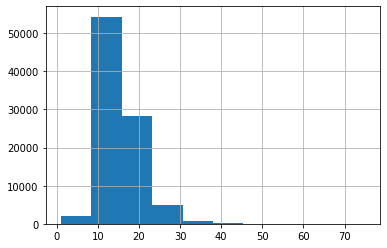

In [12]:
# First, we get an idea of what kind of speed limits we're looking at.
df.MPHOVER.hist()

In [13]:
# Before we break it down by minorities, let's get an idea of what our range is
print(f"The maximum MPHOVER we have is {df.MPHOVER.max()}")
print(f"The minimum MPHOVER we have is {df.MPHOVER.min()}")

The maximum MPHOVER we have is 75.0
The minimum MPHOVER we have is 1.0


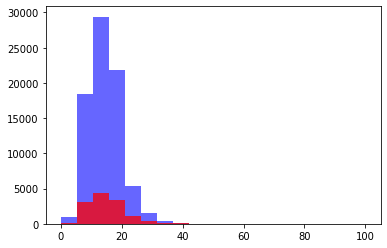

In [14]:
# ...and then, we break it down by the speed limits of the two groups we care about

wmph = df[df['MINORITY']=='W']['MPHOVER'].dropna()
mmph = df[df['MINORITY']=='M']['MPHOVER'].dropna()

bins = np.linspace(0, 100, 20)
plt.hist(wmph, bins, alpha=0.6, color="blue")
plt.hist(mmph, bins, alpha=0.75, color="red")
plt.show()

(array([2.26332441e-03, 4.49744463e-02, 7.15453882e-02, 5.31151132e-02,
        1.29423217e-02, 3.63105378e-03, 1.01241178e-03, 3.30980774e-04,
        9.97809686e-05, 4.86736432e-05, 1.94694573e-05, 2.43368216e-06,
        2.43368216e-06, 9.73472864e-06, 2.43368216e-06, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 array([  0.        ,   5.26315789,  10.52631579,  15.78947368,
         21.05263158,  26.31578947,  31.57894737,  36.84210526,
         42.10526316,  47.36842105,  52.63157895,  57.89473684,
         63.15789474,  68.42105263,  73.68421053,  78.94736842,
         84.21052632,  89.47368421,  94.73684211, 100.        ]),
 <a list of 19 Patch objects>)

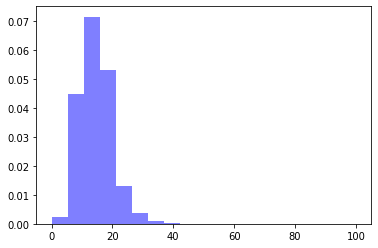

In [15]:
# The above is hard to read because we're using absolute values. 
# So, let's change it to percentage counts.
plt.hist(wmph, bins, alpha=0.5, density=True, color="blue")

# Note: if you're using an older version of matplotlib, 
# you'll need to use `normed` instead of `density` above.

(array([2.20001586e-03, 4.55674518e-02, 6.66936315e-02, 5.09318741e-02,
        1.58973749e-02, 5.50003965e-03, 2.03426124e-03, 6.78087081e-04,
        3.01372036e-04, 9.04116108e-05, 4.52058054e-05, 3.01372036e-05,
        0.00000000e+00, 1.50686018e-05, 1.50686018e-05, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]),
 array([  0.        ,   5.26315789,  10.52631579,  15.78947368,
         21.05263158,  26.31578947,  31.57894737,  36.84210526,
         42.10526316,  47.36842105,  52.63157895,  57.89473684,
         63.15789474,  68.42105263,  73.68421053,  78.94736842,
         84.21052632,  89.47368421,  94.73684211, 100.        ]),
 <a list of 19 Patch objects>)

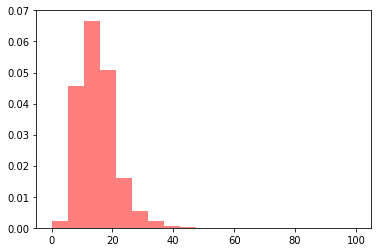

In [16]:
plt.hist(mmph, bins, alpha=0.5, density=True, color="red")

In [17]:
# There really doesn't seem to be that much difference between
# the speed limits of minorities and non-minorities. Just to doubly 
# confirm, let's do a quick mean/median between the two groups.

print(f"Non-minority: Mean:: {wmph.mean()} | Median:: {wmph.median()}")
print(f"Minority: Mean:: {mmph.mean()} | Median:: {mmph.median()}")

Non-minority: Mean:: 15.066798170895723 | Median:: 15.0
Minority: Mean:: 15.575303354746609 | Median:: 15.0


In [18]:
# So, it doesn't look like there's that much in the speed differences
# between the two groups based simply on "MINORITY".
# OK, so, let's compare all other demographic attributes. 
# We're going to use a function, which is copied here from
# Jonathan's original workbook from last year:

def comparehist(colname):
    w = df[df['MINORITY']=='W'][colname].dropna()
    m = df[df['MINORITY']=='M'][colname].dropna()
    
    if df[colname].dtype == np.float64:
        # it's numeric, plot a histogram
        bins = np.linspace(0, 100, 20)
        plt.hist(w, bins, alpha=0.5, density=True, color="blue")
        plt.hist(m, bins, alpha=0.5, density=True, color="red")
    else:
        # if not numerican, assume it's categorical and plot a bar chart of value counts normalized to percentages
        wc = w.value_counts()
        wc /= sum(wc)
        plt.bar(wc.index, wc, alpha=0.5, color=["blue", "green"])
        mc = m.value_counts()
        mc /= sum(mc)
        plt.bar(mc.index, mc, alpha=0.5, color=["red", "orange"])
        
    plt.title(colname)
    plt.show()


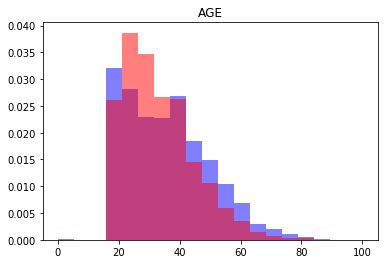

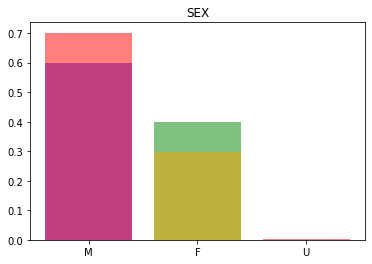

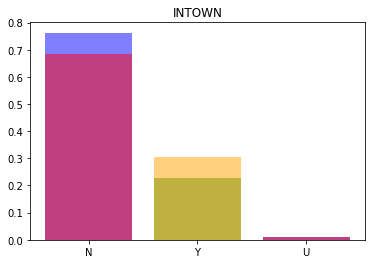

In [19]:
comparehist('AGE')
comparehist('SEX')
# comparehist('MPH')
# comparehist('MPHOVER')
# comparehist('AGENCY3')
comparehist('INTOWN')

In [20]:
# Right, let's just look at % numbers. 
pd.crosstab(df.MINORITY, df.SEX, normalize='index')

SEX,F,M,U
MINORITY,,,
M,0.296588,0.701231,0.002181
W,0.400442,0.598852,0.000706


### Logistic Regression

Right, so now we've done all of this, we're going to try predicting whether someone got a ticket or not using logistic regression. This goes a long way to showing if there's any bias in the system.

In [21]:
# Add a new column to our original dataframe to see whether someone's been ticketed or not.
# Basically, replace characters with numbers.
df["TICKETED"] = df["TYPE"].replace({"W": 0, "T": 1})

# Remove NA/NULL columns, and then sort by MPHOVER
df = df[~df['MPHOVER'].isnull()].reset_index().sort_values(by="MPHOVER")

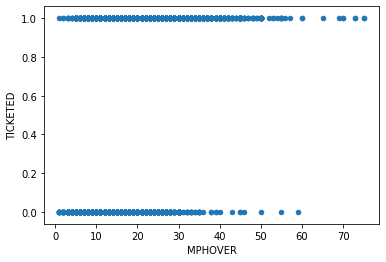

In [22]:
x = df[['MPHOVER']].values
y = df[['TICKETED']].values
df.plot(kind='scatter', x='MPHOVER', y='TICKETED')

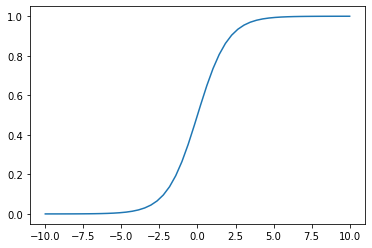

In [23]:
# Let's just have a quick look to see what a logistic function looks like.
def logistic(x):
    return 1 / (1 + np.exp(-x))

linear_range = np.linspace(-10,10)
plt.plot(linear_range, logistic(linear_range))

C:\Program Files\Python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Python37\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


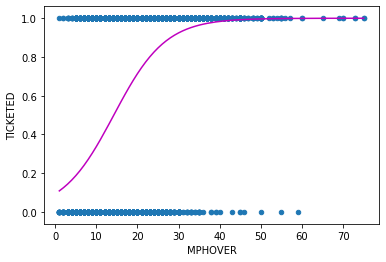

In [24]:
# ...and let's fit our data into the logistic function.
lm = LogisticRegression()
lm.fit(x,y)

df.plot(kind='scatter', x='MPHOVER', y='TICKETED')

m = lm.coef_[0]
b = lm.intercept_
line_y = m*x+b
prediction = logistic(line_y) 
plt.plot(x, prediction, '-', color='m')


OK, so above we only see one independent variable—MPHOVER—and the impact that has on getting a ticket. But, what about the other demographic data we looked at?

In [25]:
# Let's restructure this in a way logistic regression likes, 
# i.e. binary
df.SEX = df.SEX.replace({'M':0, 'F':1, 'U':0})
df.MINORITY = df.MINORITY.replace({'W':0, 'M':1})
df.INTOWN = df.INTOWN.replace({'N':0, 'Y':1, 'U':0})

df = df[~df.AGE.isnull()].reset_index()

In [26]:
# Now we include all of the above independent variables in our logistic regression.
fields = ['MPHOVER','MINORITY','SEX', 'AGE', 'INTOWN']
x = df[fields].values
y = df[['TICKETED']].values
lm = LogisticRegression() 
lm.fit(x,y)
       
# And, this gives us the coefficient values ***all other things remaining equal***. 
results = pd.DataFrame(np.exp(lm.coef_), columns=fields)
results

## REMEMBER: Positive coefficients contribute to category 1 (TICKETED) in our case and negative to category 0. 


C:\Program Files\Python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Program Files\Python37\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,MPHOVER,MINORITY,SEX,AGE,INTOWN
0,1.169127,1.461251,0.72036,0.985098,0.508197


In [27]:
lm.score(x,y)

0.6484271596223419

In [28]:
# Testing probabilities for a person with explicit qualities
# fields = ['MPHOVER','MINORITY','SEX', 'AGE', 'INTOWN']

lm.predict_proba([[20.0, 0, 0, 22, 0]])

array([[0.20657714, 0.79342286]])